# 1. Importing libraries

In [31]:
# Data processing  
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np
import pickle

# Path configuration for custom module imports  
# -----------------------------------------------------------------------
import sys  
sys.path.append('../')  # Adds the parent directory to the path for custom module imports  

# Custom functions and classes
# -----------------------------------------------------------------------
from src.preprocess import *
from src.race_prediction_model.classification import ClassificationModels

# 2. Data loading

In [32]:
df = pd.read_csv('../data/output/featured_results.csv', index_col=0)

In [33]:
df.columns

Index(['DriverId', 'TeamId', 'Position', 'GridPosition', 'Time', 'Status',
       'Points', 'round', 'circuitId', 'Winner', 'Podium', 'MeanPreviousGrid',
       'MeanPreviousPosition', 'CurrentDriverWins', 'CurrentDriverPodiums'],
      dtype='object')

Since we want to predict whether a driver will win a race, we need to remove the columns that contain information about the race result, as we cannot provide input data about something that has not yet happened.

Our target variable in this case is `Winner` (it could be `Podium` if we want to predict if a driver will finish on the podium, `Position` if we want to predict the exact position, etc.).

Therefore, we can remove `Position`, `Time`, `Status`, `Points`, `Podium`. The rest of the variables can be known before the race takes place.

In [34]:
target = 'Winner'

drop = 'Winner' if target == 'Podium' else 'Podium'

df.drop(columns=['Position', 'Time', 'Status', 'Points', drop], inplace=True)

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6433 entries, 8 to 11
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   DriverId              6433 non-null   object 
 1   TeamId                6433 non-null   object 
 2   GridPosition          6433 non-null   float64
 3   round                 6433 non-null   int64  
 4   circuitId             6433 non-null   object 
 5   Winner                6433 non-null   int64  
 6   MeanPreviousGrid      6433 non-null   float64
 7   MeanPreviousPosition  6433 non-null   float64
 8   CurrentDriverWins     6433 non-null   int64  
 9   CurrentDriverPodiums  6433 non-null   int64  
dtypes: float64(3), int64(4), object(3)
memory usage: 552.8+ KB


We can explicitly check for null values

In [36]:
df.isna().sum()

DriverId                0
TeamId                  0
GridPosition            0
round                   0
circuitId               0
Winner                  0
MeanPreviousGrid        0
MeanPreviousPosition    0
CurrentDriverWins       0
CurrentDriverPodiums    0
dtype: int64

# 3. Preprocess

In [37]:
df.select_dtypes(include='O').columns

Index(['DriverId', 'TeamId', 'circuitId'], dtype='object')

### Encoding

We only need to encode the columns `DriverId`, `TeamId`, and `circuitId`.

* `DriverId`: We will apply target encoding since we want to give more weight to drivers with more victories.

* `TeamId`: We will apply target encoding since we want to give more weight to teams with more victories.

* `circuitId`: We will use ordinal encoding, as the circuits don't have any significance beyond the fact that some teams or drivers perform better than others.

### Scaling

Since we have very few outliers in our datasets and there are no extremely high values, we will use a `MinMax` scaler.

In [38]:
encoding_methods = {"onehot": [],
                    "target": ['DriverId', 'TeamId'],
                    "ordinal" : {
                        'circuitId': df['circuitId'].unique().tolist()
                        },
                    "frequency": []
                    }
scaling = 'minmax'

df_encoded, df_scaled = preprocess(df, encoding_methods, scaling, target_variable=target)

# 4. Model selection

We are facing a binary classification problem in which we aim to predict whether a driver will win a race or not based on various data. Therefore, we will test the simplest classification algorithm, `logistic regression`, alongside a more sophisticated model like `XGBoost`.

Regarding the model metrics, `precision` is the key metric, as it is more important for us to ensure that if we predict a driver will win, they actually do, even at the cost of sometimes missing drivers who will win. However, we will also consider `f1_score`, which provides a balance between both situations.

### Model training

First, we instantiate the `ClassificationModels` class with the scaled dataset and the target variable to predict.

In [39]:
models = ClassificationModels(df_scaled, target)

We create an empty dataframe where we will store the metric results.

In [40]:
df_results = pd.DataFrame()

## 4.1 Logistic regression

In [41]:
model = "logistic_regression"

# Fit model
models.fit_model(model, file_name=model, cross_validation=10)

# Get metrics and store them
df_current_results = models.get_metrics(model)
df_current_results["model"] = model
df_results = pd.concat([df_results, df_current_results], axis=0)

### 4.1.1 Metrics

In [42]:
df_current_results.round(3)

,accuracy,precision,recall,f1,kappa,auc,average_precision,time_seconds,model
train,0.963,0.692,0.465,0.556,0.538,0.965,0.643,0.378,logistic_regression
test,0.960,0.474,0.367,0.414,0.394,0.954,0.490,0.378,logistic_regression


The `Logistic Regression` model achieves a high accuracy of 96% and an AUC-ROC of 0.95, indicating strong class discrimination.

However, performance drops when evaluating the test set, with a decrease in precision (from 0.69 to 0.47) and recall (from 0.46 to 0.37). This suggests potential overfitting to the training data, reducing the model's generalization ability.

Additionally, these metric values are not particularly strong, so we will aim to improve them using XGBoost and class balancing.

### 4.1.2 Confusion matrix

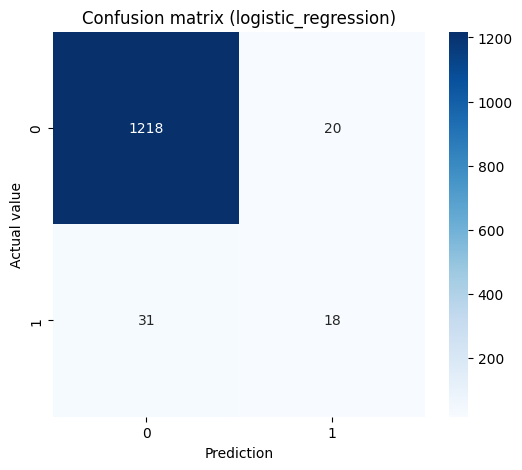

In [43]:
models.plot_confusion_matrix(model, size=(6,5))

The `confusion matrix` for `Logistic Regression` shows that the model performs well on the negative class (0) but struggles with the positive class (1):

- True negatives (TN): 1218 → Correctly classified as 0.
- False positives (FP): 20 → Incorrectly classified as 1.
- False negatives (FN): 31 → Cases of class 1 misclassified as 0.
- True positives (TP): 18 → Correctly classified as 1.

The model has high precision for class 0, but its recall for class 1 is low, capturing only 18 out of 49 positive cases (≈36.7%). This indicates difficulty in correctly identifying the minority class.

### 4.1.3 Features importance

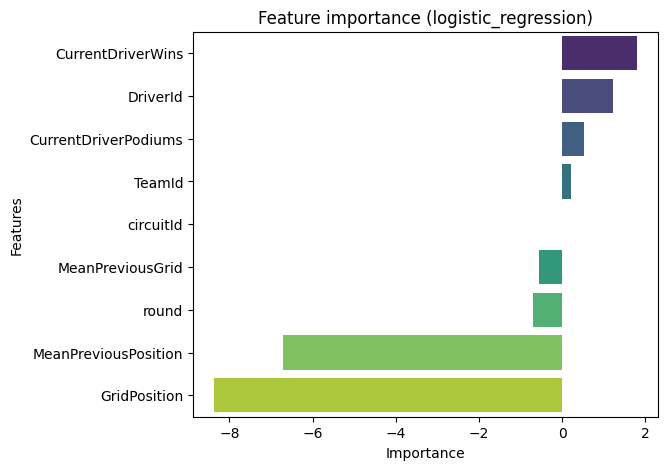

,Feature,Importance
6,CurrentDriverWins,1.793794
0,DriverId,1.212751
7,CurrentDriverPodiums,0.514550
1,TeamId,0.222296
8,circuitId,-0.003932
4,MeanPreviousGrid,-0.567614
3,round,-0.689517
5,MeanPreviousPosition,-6.704079
2,GridPosition,-8.370877


In [44]:
models.plot_predictors_importance(model, size=(6,5))

Regarding feature importance, we observe results that make sense. In absolute terms, the most significant factors are `starting grid position` and `average position in the previous races` (specifically, the last 3 races in this case).

Additionally, we see that `the number of current wins` and the `driver ID` are important features. It's worth noting that the driver ID was encoded using `target encoding`, which explains why drivers with the most wins are more likely to be predicted as winners.

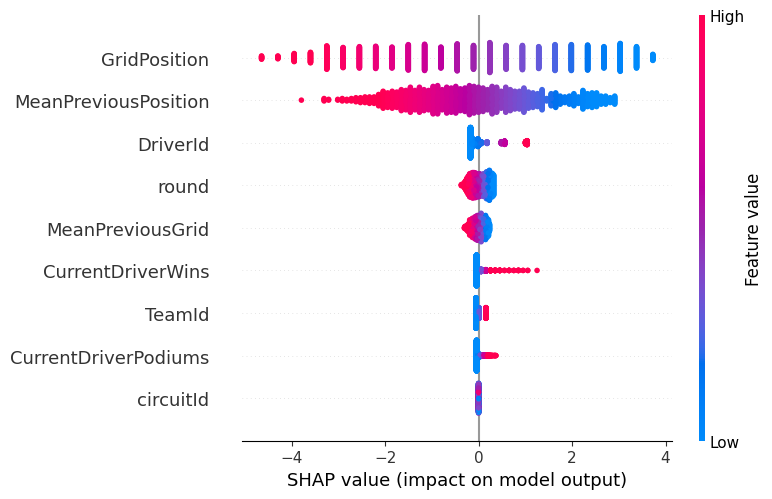

In [45]:
models.plot_shap_summary(model)

In the `SHAP diagram`, we can better visualize the impact of each feature on the model, further reinforcing our previous conclusions.  

Interestingly, while the most influential feature is the starting grid position for the current race, the previous grid positions appear to have little to no effect.

## 4.2 XGBoost

In [46]:
model = "xgboost"

# Fit model
models.fit_model(model, file_name=model, cross_validation=10)

# Get metrics and store them
df_current_results = models.get_metrics(model)
df_current_results["model"] = model
df_results = pd.concat([df_results, df_current_results], axis=0)

### 4.2.1 Metrics

In [47]:
df_current_results.round(3)

,accuracy,precision,recall,f1,kappa,auc,average_precision,time_seconds,model
train,0.971,0.803,0.559,0.659,0.644,0.981,0.784,20.956,xgboost
test,0.974,0.750,0.490,0.593,0.580,0.967,0.640,20.956,xgboost


The `XGBoost model` achieves a high accuracy of 97.4% and an AUC-ROC of 0.967, indicating excellent class discrimination, slightly improving over `Logistic Regression` in both metrics.  

Compared to Logistic Regression, XGBoost exhibits better precision on the test set (0.75 vs. 0.47), meaning it makes fewer false positive predictions. However, recall drops slightly indicating that the model still struggles to identify all positive cases, but it's still better than Logistic Regression (0.49 vs. 0.37). The F1-score (0.593) shows an improvement over Logistic Regression as well, demonstrating a more balanced trade-off between precision and recall.  

While overfitting is still present, XGBoost provides a more **robust performance overall**. To further enhance results, we could explore hyperparameter tuning and class balancing techniques.

### 4.2.2 Confusion matrix

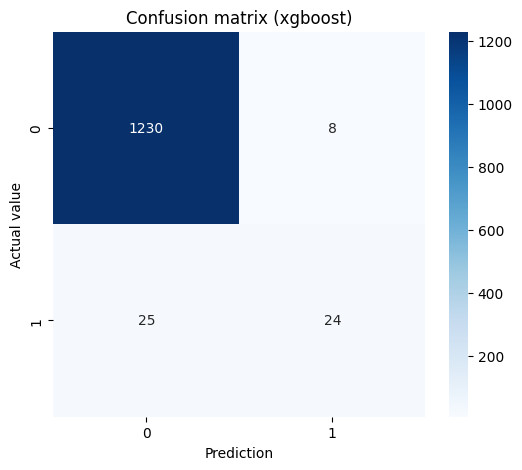

In [48]:
models.plot_confusion_matrix(model, size=(6,5))

The `confusion matrix` for `XGBoost` shows that the model performs well in classifying the negative class (0)** but still struggles with the positive class (1):

- True negatives (TN): 1230 → Correctly classified as 0.  
- False positives (FP): 8 → Incorrectly classified as 1.  
- False negatives (FN): 25 → Class 1 cases misclassified as 0.  
- True positives (TP): 24 → Correctly classified as 1.  

Compared to Logistic Regression, XGBoost significantly reduces false positives (from 20 to 8), improving precision. However, it still struggles with recall, as it only captures 24 out of 49 actual positive cases (≈49%). While this is an improvement over Logistic Regression, it suggests that the model still misses many true winners. 

### 4.2.3 Features importance

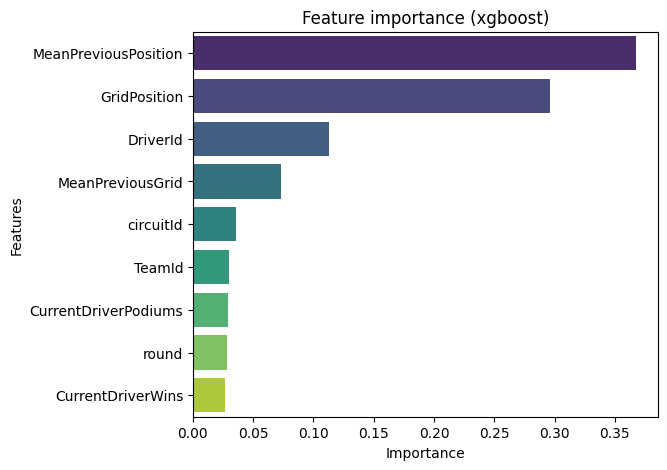

,Feature,Importance
5,MeanPreviousPosition,0.367346
2,GridPosition,0.296077
0,DriverId,0.112600
4,MeanPreviousGrid,0.073178
8,circuitId,0.036057
1,TeamId,0.029960
7,CurrentDriverPodiums,0.029184
3,round,0.028561
6,CurrentDriverWins,0.027035


In [49]:
models.plot_predictors_importance(model, size=(6,5))

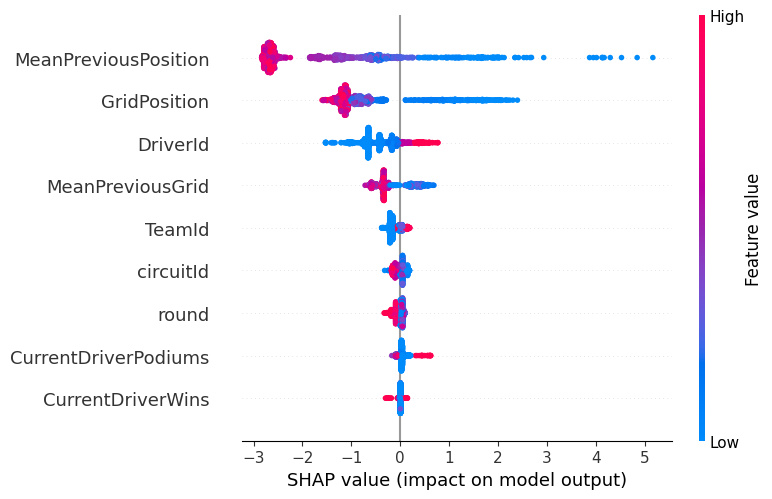

In [50]:
models.plot_shap_summary(model)

In this case, we observe that `previous finishing positions` have greater importance than the `starting grid position` for the current race.

Additionally, the `starting grid positions from previous races` and the `circuit` now carry more weight compared to the previous model, whereas current podiums and victories have less influence.

In [51]:
df_results.round(3)

,accuracy,precision,recall,f1,kappa,auc,average_precision,time_seconds,model
train,0.963,0.692,0.465,0.556,0.538,0.965,0.643,0.378,logistic_regression
test,0.960,0.474,0.367,0.414,0.394,0.954,0.490,0.378,logistic_regression
train,0.971,0.803,0.559,0.659,0.644,0.981,0.784,20.956,xgboost
test,0.974,0.750,0.490,0.593,0.580,0.967,0.640,20.956,xgboost


# 5. Class balancing

### Addressing Class Imbalance  

One of the main challenges we face is **class imbalance**. This is expected, as a Formula 1 race typically features 20 drivers, but only one wins, meaning the minority class represents just 5% of the dataset.  

A common approach to handling this issue is upsampling or downsampling. However, these techniques often introduce biases into the dataset. Instead, we will use a different method: reducing the dataset to include only relevant entries for the model.  

Many drivers have a very low probability of winning due to various factors. Therefore, we can exclude them from the dataset to improve model performance.  

### Filtering criterion

We will retain only drivers whose starting and finishing positions are below a certain threshold. This removes participants who consistently qualify and finish in poor positions, as they realistically never had a chance of winning. However, drivers who:  

- Started in a poor position but managed a strong finish will still be included.  
- Started in a good position but had a bad race will also remain in the dataset.  

This filtering process only excludes drivers who performed poorly in both sessions (qualifying and race), ensuring we keep those who are genuinely competitive in the dataset.

## 5.1 Data loading

In [52]:
df = pd.read_csv('../data/output/featured_results.csv', index_col=0)

Ahora aplicaremos el filtro. Tras diferentes pruebas, utilizaremos un filtro que solamente tome resultados en los que el piloto haya salido o llegado entre los tres primeros.

In [53]:
threshold = 3

mask = (df['Position'] <= threshold) | (df['GridPosition'] <= threshold)

df = df[mask]

target = 'Winner'
drop = 'Winner' if target == 'Podium' else 'Podium'

df.drop(columns=['Position', 'Time', 'Status', 'Points', drop], inplace=True)

Llevamos a cabo el mismo preprocesamiento que en el caso anterior.

In [55]:
encoding_methods = {"onehot": [],
                    "target": ['DriverId', 'TeamId'],
                    "ordinal" : {
                        'circuitId': df['circuitId'].unique().tolist()
                        },
                    "frequency": []
                    }
scaling = 'minmax'

df_encoded, df_scaled = preprocess(df, encoding_methods, scaling, target_variable=target)

In [56]:
models = ClassificationModels(df_scaled, target)

In [57]:
df_results_balanced = pd.DataFrame()

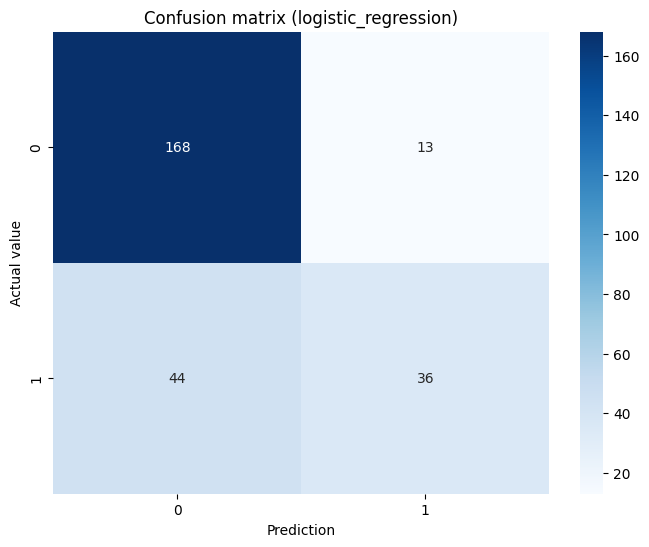

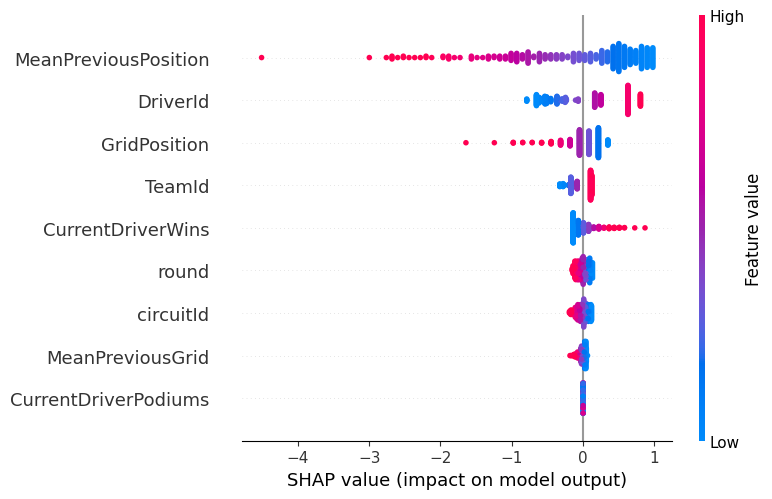

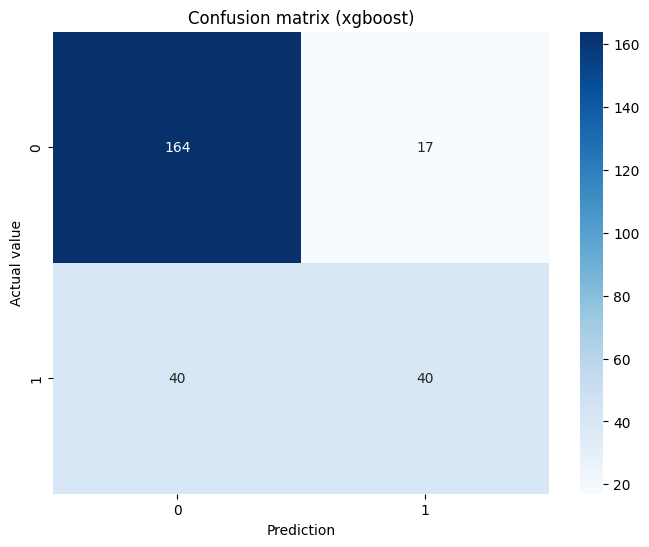

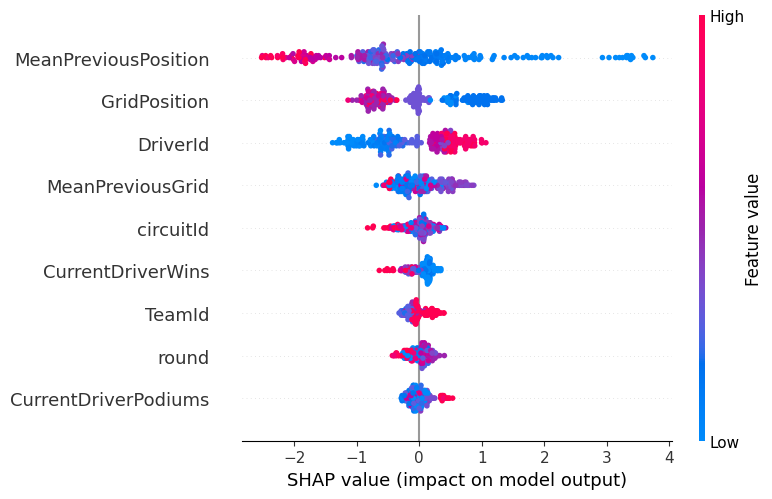

In [ ]:
model_list = ["logistic_regression", "xgboost"]

for model in model_list:    

    # Fit model
    models.fit_model(model, file_name=f"{model}_balanced", cross_validation=10)

    # Plots
    models.plot_confusion_matrix(model)
    models.plot_shap_summary(model)

    # Get metrics
    df_current_results = models.get_metrics(model)
    df_current_results["model"] = model
    df_results_balanced = pd.concat([df_results_balanced, df_current_results], axis=0)

In [59]:
df_results_balanced.round(3)

,accuracy,precision,recall,f1,kappa,auc,average_precision,time_seconds,model
train,0.827,0.642,0.453,0.531,0.429,0.831,0.621,0.159,logistic_regression
test,0.782,0.735,0.450,0.558,0.424,0.790,0.653,0.159,logistic_regression
train,0.893,0.842,0.618,0.713,0.649,0.945,0.852,12.650,xgboost
test,0.782,0.702,0.500,0.584,0.441,0.808,0.712,12.650,xgboost


# 6. Conclusions

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>accuracy</th>
      <th>precision</th>
      <th>recall</th>
      <th>f1</th>
      <th>kappa</th>
      <th>auc</th>
      <th>average_precision</th>
      <th>time_seconds</th>
      <th>model</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>train</th>
      <td>0.963</td>
      <td>0.692</td>
      <td>0.465</td>
      <td>0.556</td>
      <td>0.538</td>
      <td>0.965</td>
      <td>0.643</td>
      <td>0.378</td>
      <td>logistic_regression</td>
    </tr>
    <tr>
      <th>test</th>
      <td>0.960</td>
      <td>0.474</td>
      <td>0.367</td>
      <td>0.414</td>
      <td>0.394</td>
      <td>0.954</td>
      <td>0.490</td>
      <td>0.378</td>
      <td>logistic_regression</td>
    </tr>
    <tr>
      <th>train</th>
      <td>0.971</td>
      <td>0.803</td>
      <td>0.559</td>
      <td>0.659</td>
      <td>0.644</td>
      <td>0.981</td>
      <td>0.784</td>
      <td>20.956</td>
      <td>xgboost</td>
    </tr>
    <tr>
      <th>test</th>
      <td>0.974</td>
      <td>0.750</td>
      <td>0.490</td>
      <td>0.593</td>
      <td>0.580</td>
      <td>0.967</td>
      <td>0.640</td>
      <td>20.956</td>
      <td>xgboost</td>
    </tr>
  </tbody>
</table>
</div>

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>accuracy</th>
      <th>precision</th>
      <th>recall</th>
      <th>f1</th>
      <th>kappa</th>
      <th>auc</th>
      <th>average_precision</th>
      <th>time_seconds</th>
      <th>model</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>train</th>
      <td>0.827</td>
      <td>0.642</td>
      <td>0.453</td>
      <td>0.531</td>
      <td>0.429</td>
      <td>0.831</td>
      <td>0.621</td>
      <td>0.159</td>
      <td>logistic_regression</td>
    </tr>
    <tr>
      <th>test</th>
      <td>0.782</td>
      <td>0.735</td>
      <td>0.450</td>
      <td>0.558</td>
      <td>0.424</td>
      <td>0.790</td>
      <td>0.653</td>
      <td>0.159</td>
      <td>logistic_regression</td>
    </tr>
    <tr>
      <th>train</th>
      <td>0.893</td>
      <td>0.842</td>
      <td>0.618</td>
      <td>0.713</td>
      <td>0.649</td>
      <td>0.945</td>
      <td>0.852</td>
      <td>12.650</td>
      <td>xgboost</td>
    </tr>
    <tr>
      <th>test</th>
      <td>0.782</td>
      <td>0.702</td>
      <td>0.500</td>
      <td>0.584</td>
      <td>0.441</td>
      <td>0.808</td>
      <td>0.712</td>
      <td>12.650</td>
      <td>xgboost</td>
    </tr>
  </tbody>
</table>
</div>